
# Sử dụng mô hình Generative Adversial Network (GAN) huấn luyện trên tập dữ liệu MNIST và MNIST Fashion




Mô hình GAN sử dụng 2 mạng huấn luyện là mạng Generator - G và mạng Discriminator - D. Mạng Generator sẽ cố gắng tạo ra những tập dữ liệu mới từ tập dữ liệu ban đầu, còn mạng Discriminator có nhiệm vụ phân biệt đâu là tập dữ liệu cũ và đâu là tập dữ liệu mới tạo ra.

# Quá trình chuẩn bị

In [45]:
import torch
import torch.optim as opt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle as pkl
%matplotlib inline

Ở bước chuẩn bị dữ liệu ban đầu cần phải transform tập dữ liệu để có thể sử dụng với pytorch

In [46]:
# number of subprocesses to use for data loading
num_workers = 0

# Chia mẫu thành các mini-batch
batch_size = 64

# transform dữ liệu sang kiểu tensor để pytorch có thể hoạt động được
transform = transforms.ToTensor()

# Handwriting digits
train_data = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
# MNIST Fashion
# train_data = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

# Data Loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,num_workers=num_workers)

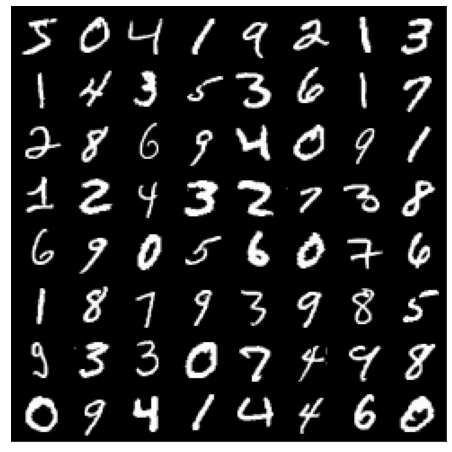

torch.Size([64, 1, 28, 28])


In [47]:
#Hiển thị một số hình ảnh của MNIST

dataiter = iter(train_loader)
imgs, labels = dataiter.next()

def visualize_datasets(imgs):

    # make_grid - Tạo layout hiện thị các 
    imgs = torchvision.utils.make_grid(imgs)
    
    # transfoming ngược lại từ tensor sang dạng numpy để có thể thể hiện ảnh
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

visualize_datasets(imgs)

print(imgs.size())

# Mạng Discriminator

- Đầu vào của mạng Discrimnator là ảnh thực hoặc ảnh được tạo ra từ mạng Generator. Đầu ra của mạng là 0 hoặc 1 thể hiện cho kết của ảnh là giả / thật 
- Sử dụng Linear Regression cho quá trình huấn luyện
- Sử dụng hàm kích hoạt Leaky ReLu
- Sau mỗi lớp Linear Regression, ta sẽ dùng thêm dropout để loại bỏ một số mẫu, giúp tranhs việc bị overfitting


In [48]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_size),
        )
        
    def forward(self, input):
        # flatten image
        input = input.view(-1, 28*28)
        out = self.model(input)

        return out

# Mạng Generator
- Đầu vào của mạng Generator là tập hợp các vector nhiễu khởi tạo ngẫu nhiên theo phân phối Gaussian.
- Sử dụng Linear Regression cho quá trình huấn luyện
- Sử dụng hàm kích hoạt Leaky ReLu
- Hàm kích hoạt cho lớp cuối cùng là Tanh giúp mở rộng khoảng giá trị [-1, 1] thay vì [0, 1] như Sigmoid

In [49]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, output_size),
        )

    def forward(self, input):
        
        # final layer with tanh applied
        out = torch.tanh(self.model(input))

        return out

#Các tham số sử dụng của các mạng

In [50]:
# Tham số mạng Discriminator

# Kích thước ảnh đầu vào của mạng discriminator (28*28)
input_size = 784
# Kích thước đầu ra của mạng discriminator (real or fake)
d_output_size = 1
# Kích thước lớp hidden layer cuối discriminator
d_hidden_size = 32

# Tham số mạng Generator

# Kích thước vector nhiễu generator
z_size = 100
# Kích thước ảnh đẩu ra của mạng generator (generated image)
g_output_size = 784
#  Kích thước lớp hidden layer cuối generator
g_hidden_size = 32

# Khai báo mạng Generator & Discriminator

In [51]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print(G)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=12

# Tính toán hàm mất mát của mạng Discriminator & Generator

- Hàm mất mát của mạng Discriminator
  - Lượng mất mát của mạng Discriminator được tính bằng tổng mất mát trên dữ liệu ban đầu và mất mát trên dữ liệu mới tạo ra.
  - Bởi đầu ra của mạng Discriminator là 1 hoặc 0 nên giá trị mất mát của mạng sẽ phải thể hiện được điều đó
  - Hàm mất mát của mạng sẽ sử dụng **BCEWithLogitsLoss** dựa trên hàm Sigmoid và hàm BCE - Binary Cross Entropy
  - Để giúp cho mạng Discriminator có thể phân biệt tốt hơn thì ta có thể giảm label từ 1.0 xu 0.9. Hàm sẽ sử dụng tham số **smooth**, nếu **smooth = True** thì ta sẽ tiến hành smooth label bằng cách **labels = torch.ones(size) * 0.9**  
  - Với tập dữ liệu giả do Generator tạo ra, ta mong muốn D(fake) = 0

- Hàm mất mát của mạng Generator
  - Hàm mất mát của mạng G tính toán giống với của Discrimination nhưng với những label bị ngược. Mục tiêu của Generator là để D(fake) = 1.



In [52]:
# Tính toán mất mát
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    
    if smooth:
        
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
        
    # Tính loss với Sigmoid và BCE
    criterion = nn.BCEWithLogitsLoss()
  
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size) 
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Tối ưu

Ở đây ta muốn cập nhật tham số cho mạng Discriminator và Generator 1 cách độc lập.\
Ta sử dụng 2 hàm Adam để thực hiện tối ưu


In [53]:

# Optimizers
learing_rate = 1e-3

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), learing_rate)
g_optimizer = optim.Adam(G.parameters(), learing_rate)

# Quy trình huấn luyện
Quá trính huấn luyện cho mạng Discriminator và mạng Generator diễn ra đồng thời trong 1 epoch. Ta sẽ sử dụng hàm **real_loss** và **fake_loss** để tính mất mát của mạng Discriminator

### Quá trình huấn luyện mạng Discriminator
1. Tính hàm loss của Discrimtator dựa trên ảnh gốc trong tập ảnh test        
2. Tiến hành sinh ảnh giả
3. Tính hàm loss của mạng Discrimination trên ảnh giả     
4. Cộng kết quả 2 hàm loss khi tính trên ảnh thật và ảnh sinh
5. Thực hiện lan truyền ngược và tối ưu để cập nhật tham số cho mạng Discriminator

### Quá trình huấn luyện mạng Generator
1. Sinh ảnh giả
2. Tính hàm loss của mạng generator
3. Thực hiện lan truyền ngược và tối ưu để cập nhật tham số cho mạng Generator

#### Lưu mẫu

Lưu lại các kết quả mất mát sau mỗi bước training. Để sử dụng trong việc đánh giá kết quả trên từng bước và thống kê.

In [54]:

# Epochs training
num_epochs = 100

# Lưu lại kết quả của hàm mất mát và các mẫu sinh
samples = []
losses = []

print_every = 400

# Tập vector nhiều ngẫu nhiên
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Bắt đầu huấn luyện các mạng
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Rescale ảnh sử dụng cho Leaky ReLU
        real_images = real_images*2 - 1  # input từ [0,1) cho [-1, 1)
        
        # ============================================
        #            Huấn luyện cho DISCRIMINATOR
        # ============================================
        
        # set d_optimizer = 0 chuẩn bị cho lan truyền ngược
        d_optimizer.zero_grad()
        
        # 1. Huấn luyện với ảnh train

        # Tính hàm mất mát của discriminator với ảnh train 
        # sử dụng smooth với real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Huấn luyện với ảnh sinh
        
        # Sinh ảnh giả
        # không sử dụng gradient cho ảnh sinh ở trong quá trình huấn luyện discriminator
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        
        # Tính hàm mất mát của discriminator với ảnh sinh        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Cộng kết quả 2 hàm loss khi tính trên ảnh thật và ảnh sinh
        d_loss = d_real_loss + d_fake_loss

        # Lan truyền ngược + tối ưu + cập nhật hệ số
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            Huấn luyện GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Huấn luyện với ảnh sinh vầ label ngược
        
        # Tạo ảnh sinh
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Tính hàm mất mát của discriminator với ảnh sinh nhưng với label ngược
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # sử  dụng real_loss thay vì fake_loss vì label ngược
        
        # Lan truyền ngược + tối ưu + cập nhật hệ số
        g_loss.backward()
        g_optimizer.step()

        # Print
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## Sau mỗi epoch
    # bổ sung discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # tạo và lưu mẫu sinh
    G.eval() # eval mode - chuyển sang chể độ đánh giá
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train()


# Lưu lại tất cả các mẫu đã sinh
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3952 | g_loss: 0.6651
Epoch [    1/  100] | d_loss: 0.8430 | g_loss: 3.3848
Epoch [    1/  100] | d_loss: 1.1072 | g_loss: 1.5912
Epoch [    2/  100] | d_loss: 1.1317 | g_loss: 2.0266
Epoch [    2/  100] | d_loss: 1.3139 | g_loss: 1.0443
Epoch [    2/  100] | d_loss: 1.1048 | g_loss: 1.2294
Epoch [    3/  100] | d_loss: 0.5750 | g_loss: 3.3398
Epoch [    3/  100] | d_loss: 0.7709 | g_loss: 1.5492
Epoch [    3/  100] | d_loss: 0.8370 | g_loss: 1.8738
Epoch [    4/  100] | d_loss: 1.0253 | g_loss: 1.8943
Epoch [    4/  100] | d_loss: 1.1167 | g_loss: 1.0144
Epoch [    4/  100] | d_loss: 1.1791 | g_loss: 1.1362
Epoch [    5/  100] | d_loss: 0.9005 | g_loss: 2.9162
Epoch [    5/  100] | d_loss: 0.9915 | g_loss: 1.8383
Epoch [    5/  100] | d_loss: 1.1719 | g_loss: 1.4434
Epoch [    6/  100] | d_loss: 1.0308 | g_loss: 1.5396
Epoch [    6/  100] | d_loss: 0.9293 | g_loss: 1.6078
Epoch [    6/  100] | d_loss: 1.2273 | g_loss: 1.2870
Epoch [    7/  100] | d_loss

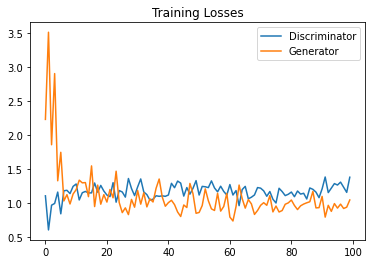

In [55]:
# Bảng thể hiện kết quả của hàm mất mát của 2 mạng/mô hình

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Xem lại các ảnh sinh trong quá trình huấn luyện


In [72]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(8,8), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [73]:
# Lấy các mẫu từ file được lưu từ trước
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

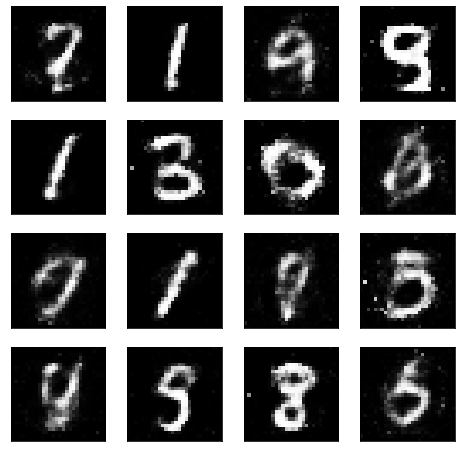

In [74]:
# -1 => kết quả của epoch cuối
view_samples(-1, samples)

Các ảnh sinh ra ở mỗi X epoch

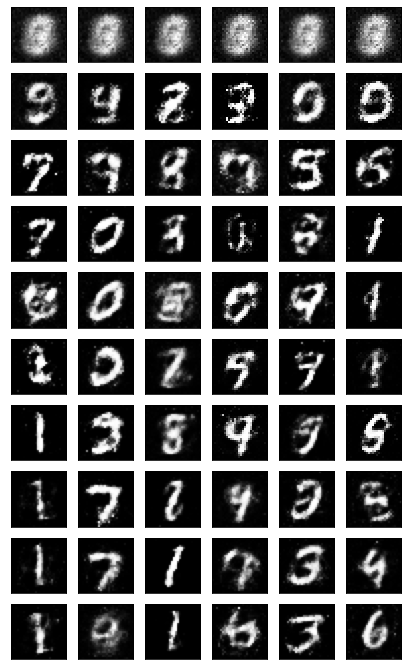

In [59]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Tự sinh ra ảnh từ kết quả training của mạng Generator

Có thể tạo ra một ảnh mới từ kết quả training bằng cách sử dụng checkpoint mà ta đã lưu được\
Chỉ cần truyền 1 vector nhiễu là có thể sinh ra ảnh sinh tại điểm checkpoint đó




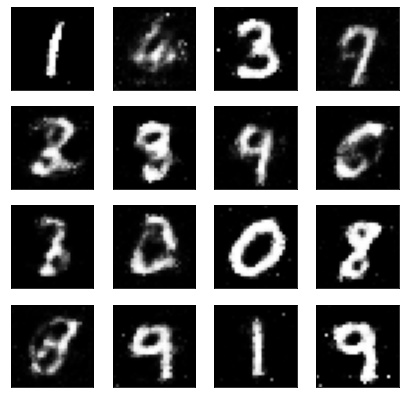

In [60]:
# Vector nhiễu z ngẫu nhiên 
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])